# Galactic Collision Modelling
### By Michael Hench et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from antennae import Leapfrog as lf
from antennae.Galaxy import Galaxy
from antennae.GalaxyTools import GalaxyTools as gt

#### Initial Conditions

Before we can set up our system of two galaxies, we must first calculate the initial conditions, starting with our unit system. In order to simplify calculations, we can define our unit system $L_{unit}, t_{unit}, M_{unit}$ such that $G = 1$. Given that we are following in the footsteps of Toomre & Toomre's 1972 paper "Galactic Bridges and Tails" in our simulation, we will also set $t_{unit} = 10^8 years$. Given that Toomre & Toomre chose the initial separation distance to be $R_{min} = 25 kpc$, we will set $L_{unit} = 1 kpc$. From here, we diverge from Toomre and Toomre: given that we have arbitrarily set $G = 1$, we must change the mass unit from $M_{unit} = 10^{11} M_{\odot}$. From our chosen values for the unit system, we can calculate the mass unit as follows:


In [2]:
# mass unit (
M = (3.086e19)**3 / (1e8 * 365.25 * 86400)**2 / 6.67e-11 / 1.989e30
print(f"Mass unit: {M} solar masses")

Mass unit: 22244324.092036594 solar masses


Given that we know that $M_{unit} \approx 2.224 * 10^7 M_{\odot}$, we can calculate the mass of the galaxies as $M = 10^{11} M_{\odot} * \frac{1 M_{unit}}{22244324.092036594 M_{\odot}} \approx 4495.5 M_{unit}$. Therefore, we can now fully define our input parameters:

In [3]:
# set input parameters
rmin = 25
e = 0.5     # eccentricity
G = 1
M = 4495.5
phi = 0     # apocenter

Now that we have successfully calculated our unit system and defined our input parameters, we can move onto calculating the initial conditions for our galactic cores. To do this, we can use the following equations for Kepler orbits:
(1) $r(\phi) = \frac{R_{min} (1 + \varepsilon)}{1 - \varepsilon \cos \phi}$
(2) $v_r = -\varepsilon \sqrt{\frac{G(M_1 + M_2)}{R_{min}(1 + \varepsilon)}} \sin \phi$
(3) $v_{\phi} = -\varepsilon \sqrt{\frac{G(M_1 + M_2)}{R_{min}(1 + \varepsilon)}} (1 - \varepsilon \cos \phi)$

Note: here we only calculate the initial positions and velocities in the xy-plane. This was an intentional choice, as it is much easier to generate the two galaxies on the xy-plane and then rotate them using standard rotation matrices such that the Galaxy A and Galaxy B have arguments of periapsis $\omega_A = \omega_B = - \frac{\pi}{6}$ and inclinations $i_A = i_B = \frac{\pi}{3}$, rather than generating the galaxies directly in 3D Cartesian space.

In [4]:
# calculate initial core positions in the xy-plane using equations for Kepler orbits
r = rmin * (1 + e) / (1 - e * np.cos(phi))

# calculate initial core velocities in the xy-plane using equations for Kepler orbits
vr = -e * np.sqrt(2 * G * M / (rmin * (1 + e))) * np.sin(phi)
vphi = np.sqrt(2 * G * M / (rmin * (1 + e))) * (1 - e * np.cos(phi))

# convert from polar coordinates to 2D Cartesian coordinates
x = r * np.cos(phi)
y = r * np.sin(phi)
vx = vr * np.cos(phi) - vphi * np.sin(phi)
vy = vr * np.sin(phi) + vphi * np.cos(phi)

# print out initial galactic core positions and velocities in the xy-plane
print(
    f"Initial conditions in xy-plane:\n"
    f"   Position A: ({x / 2}, {y / 2})\n"
    f"   Velocity A: ({vx / 2}, {vy / 2})\n\n"
    f"   Position B: ({-x / 2}, {-y / 2})\n"
    f"   Velocity B: ({-vx / 2}, {-vy / 2})"
)

Initial conditions in xy-plane:
   Position A: (37.5, 0.0)
   Velocity A: (-0.0, 3.871046370169182)

   Position B: (-37.5, -0.0)
   Velocity B: (0.0, -3.871046370169182)


#### Galactic Setup & Collision

Now that we have calculated the initial conditions, we can generate the galaxies. To do this, we first generate the two galaxies at the origin and with no initial velocity using the Galaxy constructor, rotate the two galaxies such that they have the desired inclinations and arguments of periapsis, and finally modify them so they have the correct initial positions and velocities:

In [5]:
# generate new galaxies
# rotations: z = -30, then x = -60, then z = 30
galaxy_1 = Galaxy(r_min=rmin, theta=[-np.pi / 6, -np.pi / 3, np.pi/6], axis='zxz', m=M, name="Galaxy #1")
galaxy_2 = Galaxy(r_min=rmin, theta=[-np.pi / 6, np.pi/3, np.pi / 6], axis='zxz', m=M, name="Galaxy #2")

# rotate core initial positions
galaxy_1_pos = np.array([x / 2, y / 2, 0])
galaxy_2_pos = np.array([-x / 2, -y / 2, 0])

# move galaxies
galaxy_1.move_galaxy(galaxy_1_pos[0], galaxy_1_pos[1], galaxy_1_pos[2])
galaxy_2.move_galaxy(galaxy_2_pos[0], galaxy_2_pos[1], galaxy_2_pos[2])

# set core initial velocities
galaxy_1.add_init_vel(vx / 2, vy / 2, 0)
galaxy_2.add_init_vel(-vx / 2, -vy / 2, 0)

Let's plot the two galaxies to make sure the initial setup looks correct:

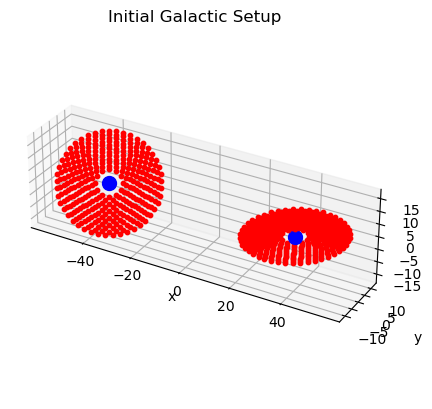

In [6]:
# plot galaxies
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
galaxy_1.plot_galaxy(fig, ax)
galaxy_2.plot_galaxy(fig, ax)

# set aspect ratio equal
ax.set_aspect("equal")
ax.set_title("Initial Galactic Setup")
plt.show()

Given their initial elliptic encounter, the two galaxies appear to be correctly set up. Next, we run the leapfrog integration code to simulate the galaxy collisions for 1500 time steps:

In [7]:
# leapfrog integration
lf.main(galaxy_1, galaxy_2)

100%|██████████| 1500/1500 [00:04<00:00, 372.82it/s]


Now that we've run leapfrog integration on the galaxies, we're almost done! Now, we just need to create animations of the galaxy collisions. We'll do this by first defining a dictionary with the desired camera angles, then generating the plots with `matplotlib`, and finally animating the plots with `ffmpeg`:

In [8]:
# define desired video angles
plots = {"top": (90, 90), "side": (0, 0), "front": (0, 90), "custom": (0, -45)}

# generate all videos
for name, view_angle in plots.items():
    gt.gen_sim("data/leapstep_latest.csv", 686, 750, view_angle)
    gt.make_video(name)

# remove plt objects
plt.close("all")